# PyGRAPES Simulation script

## with default settings, this requires a GPU and uses approximately 5GB of VRAM. 
#### The simulation reconstructs a Au Siemens Star with height of 5 nm from simulated data at a wavelength of 6.02 keV and incidence angle of 0.7 degrees. 
#### running the notebook on CPU is in principle possible, but has not been tested.

### import necessary packages

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import time
# import scipy.io
import h5py
import matplotlib.patches as patches
import sys
import torchvision.transforms as transforms
import random
import gc
import torchvision
from datetime import datetime
from skimage.draw import disk, ellipse
from scipy.ndimage import gaussian_filter
from IPython.display import display, clear_output
from torchvision.transforms import v2
import os
import re 

In [2]:
import pygrapes_testbuild as pg 

## Check CUDA is available and set default device.

### in principle, the code should be able to run without a CUDA device, but this has not been tested. 

In [3]:
print("cuda device count:",torch.cuda.device_count())
print("cuda available:",torch.cuda.is_available())
if torch.cuda.is_available():
    torch.set_default_device('cuda:0')
    torch.cuda.set_device('cuda:0')
    print("setting default device to cuda")
    num_gpus = torch.cuda.device_count()

    for i in range(num_gpus):
        # Get device properties
        # device = torch.device(f'cuda:{i}')
        properties = torch.cuda.get_device_properties(torch.device(f'cuda:{i}'))

        # Print the total memory on the current GPU
        print(f"GPU {i}: {properties.name}, Total Memory: {properties.total_memory / (1024 ** 3):.2f} GB")

    print("CUDA version:", torch.version.cuda)
    current_device = torch.cuda.current_device()
    print("current CUDA device is", current_device)
else: 
    print("cuda is not available. default device is CPU. Not tested")


def gpu_memcheck():
    allocated_memory = torch.cuda.memory_allocated()
    print("Currently allocated memory:", allocated_memory // (1024 * 1024), "MB")


cuda device count: 2
cuda available: True
setting default device to cuda
GPU 0: NVIDIA GeForce RTX 3090, Total Memory: 23.69 GB
GPU 1: NVIDIA GeForce RTX 3090, Total Memory: 23.69 GB
CUDA version: 11.8
current CUDA device is 0


# Input Settings 

### The following 3 cells are where reconstruction settings are defined, such as simulation size, resolution, wavelength, and many others.

## (1/3)  Define Initial volume size and detector window size

In [4]:
voxel_size = torch.tensor((5e-9,40e-9)) # (x,y) (normal to surface, perpendicular to x-ray propagation direction)
slab_thickness = torch.tensor(500e-9) #z-direction resolution, parallel to x-ray propagation direction (thickness of 1 slice in multislice)
full_sim_size = [1300,250,750] #a tuple specifying x,y,z size of the full volume.
params_size = [10,full_sim_size[1],full_sim_size[2]] # a tuple specifying x,y,z size of optimizable structure (default y, and z are the same as full_sim_size).
crop_window_size = [400,180] #[vertical pixels, horizontal pixels] equivalent to the window size of the detector used in in conventional ptychography ("asize" in ptychoshelves, for example).
print("Voxel size, x:", (voxel_size[0]*1e9).item(), "nm, y:",(voxel_size[1]*1e9).item(), "nm")
print("Slab thickness:", (slab_thickness*1e9).item(),"nm")


probe_buffer = 0 #not used, but leave as 0
shift_amount = 0 #not used, but leave as 0


Voxel size, x: 5.0 nm, y: 40.0 nm
Slab thickness: 500.0 nm


## (2/3) Define Experimental Wavelength, and define any refractive indices to be used in the reconstruction.

##### the code refers to Audelta and Aubeta but these can be changed for other materials if the variable name is kept the same.

In [5]:
lambda_val = torch.tensor(1.99983862803066e-10) #simulation Wavelength. Default  = 6.02 keV (commonly used at cSAXS, PSI)
Audelta = torch.tensor(7.99106419e-05) #Since this simulation is only Au, we are just defining Au delta and beta for this energy.
Aubeta = torch.tensor(1.24435501e-05) #Since this simulation is only Au, we are just defining Au delta and beta for this energy.



## (3/3) Define Reconstruction specific Parameters. 

In [6]:
# Optimization settings.
using_n_scans_per_pixel = True #leave as true
do_gradient_accumulation = True #whether structure is optimized after each scan (false), or after all scans are calculated (True) . Best left as true.
load_previous = False #if loading a previously saved/optimised 
use_per_scan_TV = False #True means TV is calculated just for scan region rather than entire volume. best to leave as false.
use_multiple_probe_modes = True #true probe mode modelling is not  implemented, but leave as true regardless.
use_noise = True #best left as true, if noise is not needed, you can set noise to zero and noise LR to zero. False disables noise modelling entirely.
optimize_scan_offsets = True #whether subpixel shifts and scan positions are optimized. Can leave as true, and set LR to zero.
oversample_structure = True #whether to apply oversampling, more z slices than are used in the simulation. Leave as true, and set to 1, to not use oversampling.
oversample_factor = 1 #leave as 1 to effectively turn oversampling off.

# set learning rates and initial guesses.
init_xr_scaling_factor = 0.02 #the magnitude (in voxels) of random fluctuatoin of your initial guess.
init_xr_substrateamt = 0.00 #provide an offset of all initial values of initial guess.
init_xr_learning_rate = 1e5 #initial learning rate seems high, but 1e5 has been tested to work reasonably well. 
grads_target = 0.1 #not used, leave at 0.1
scan_positions_LR_fine = 1e-15 #per scan position optimization
scan_positions_LR_coarse = 5e-15#position optimization of an entire set of scans. useful for coarse motor translations in stitch scans.
probe_prop_LR = 1e-4 #not used at the moment.
noise_std = 0 #noise init guess follows a gaussian dist, this provides Standard dev.
noise_mean = 0 #noise init guess follows a gaussian dist, this provides mean.
probe_grads_target = 1.0e-8 #rather than a learning rate, the probe has an average value of gradients, so that optimization is on average around the magnitude of this parameter

#total variation regularization
tvx_strength = 1 #to change the relative intensity of total variation in X direction. Not used in demo script.
tvy_strength = 1 #to change the relative intensity of total variation in Y direction. Best left at 1 initially.
tvz_strength = 1 #to change the relative intensity of total variation in Z direction. Best left at 1 initially.
total_TV_strength = 1e-3 #total contributoin of ALL total variation penalty.

#additional simulation settings.
substrate_layers = 200 #number of layers from the bottom upwards of substrate. This shuold be enough to fully reflect/absorb the incoming beam.
probe_substrate_buffer = 2 #extra spacing between probe and substrate.
top_buffer = 0 #add padding in the final multislice component if the beam reflects too early or too steeply.
pre_prop_dist_multiplier = 1.5 #add extra propagation distance before the beam encounters the structure.
post_prop_dist_multiplier = 1 #add extra propagation distance after the beam encounters the structure.
test_inc_angle = 0.7 # the incidence angle to test out these settings.
slab_pad_pre = 0 #add extra slices, not used, but necessary atm for code to run.
slab_pad_post = 0 #add extra slices, not used , but necessary atm for code to run.

# hyperparamters
num_iters = 50 #number of iteratoins to run for.
probestart = 2 #iteration number at which the probe will begin optimising.
tv_start = 2 #iteration number at which TV penalty will begin to apply.
patience = 5 #number of iterations to wait for reducing LR if loss function is increasing.
divergence_count_start = 5 #when LR scheduling begins


In [21]:
gpu_memcheck()

Currently allocated memory: 0 MB


## Load scan positions, define ROI of scans, and specify incidence angle:
### An incidence angle must be defined for each subscan, even if they are the same.
### This simulation script comes with a premade position and scan list (demo_pz_values.npy,demo_px_values.npy). You can modify it yourself, or load your own one in as needed.


subscan 0 loaded
size of scans in ROI: 159
scan_categories [0.]


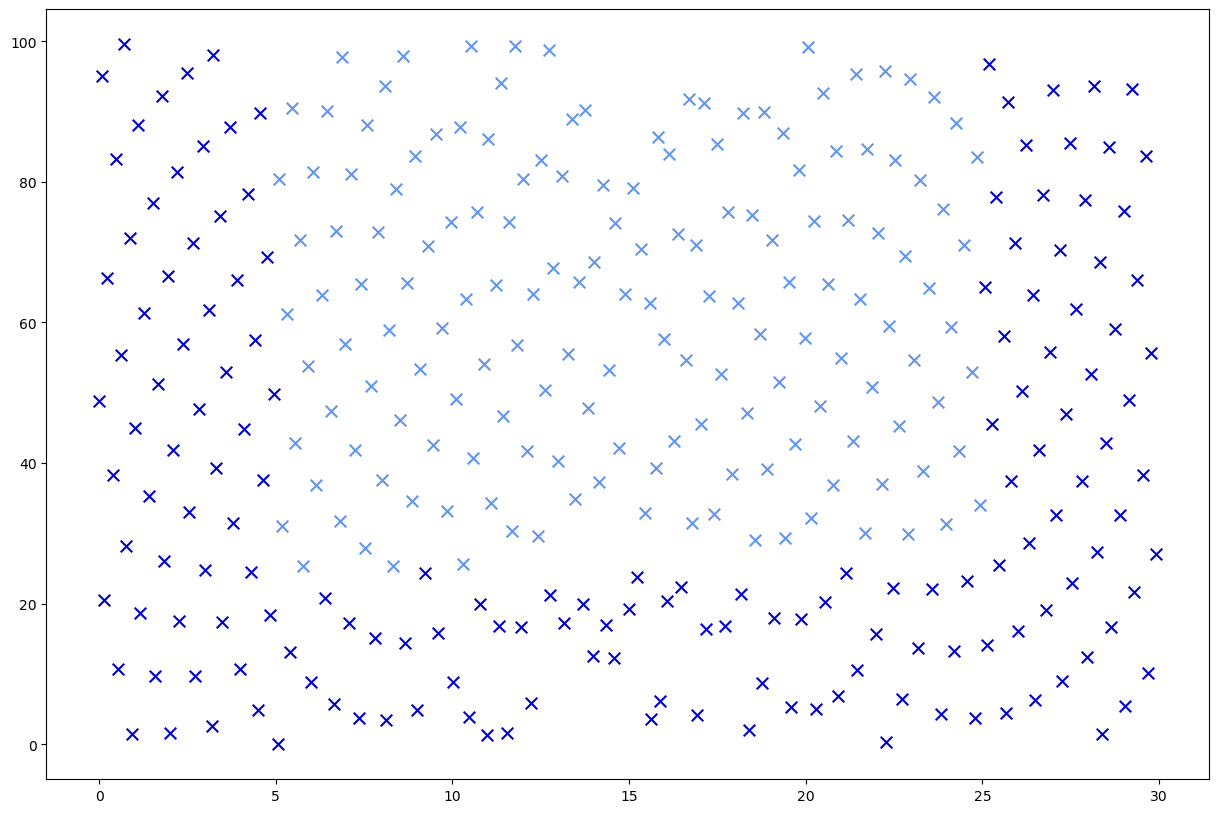

In [23]:
inc_angle_list,scan_identifier_list,num_scans,ROI_inds_sub,corrected_ROI_inds,ROI_inds,cvals,all_px_values,all_pz_values,full_scan_identifier_list = pg.load_scan_positions()
pg.plot_scan_points(cvals,full_scan_identifier_list,all_px_values,all_pz_values)

## Convert scan positions into voxel positions. 
### This includes discretization to the nearest voxel. Discretization errors are compensated in the simulation through probe shifts, which are also calculated. 
#### Scan/probe positions are optimized during reconstruction according to their learning rate. Set learning rate to 0 to disable this.

num scans in this sim 159


/tmp/ipykernel_2047249/3624004640.py:33: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  zposindex.append((int(np.round(pz_voxels[i]-scan_size_z/2)+1),int(np.round(pz_voxels[i]+scan_size_z/2+1)+1)))
/tmp/ipykernel_2047249/3624004640.py:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  yposindex.append((int(np.round(px_voxels[i]-scan_size_y/2)+1),int(np.round(px_voxels[i]+scan_size_y/2+1)+1)))


Text(0.5, 1.0, 'subpixel shifts Y')

<Figure size 640x480 with 0 Axes>

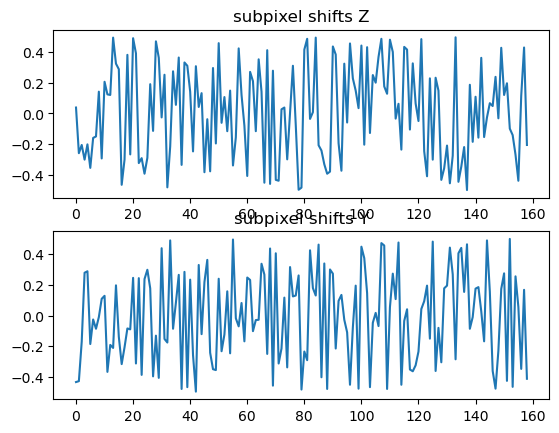

In [24]:
num_scans = len(ROI_inds[0])
print("num scans in this sim",num_scans)

scan_size_y = params_size[1]
scan_size_z = params_size[2]


plt.figure()
px_voxels = (all_px_values[ROI_inds]*1e-6) / voxel_size[1].cpu().numpy()
pz_voxels = (all_pz_values[ROI_inds]*1e-6) / slab_thickness.cpu().numpy()
px_voxels = px_voxels.reshape(-1,1) 
pz_voxels = pz_voxels.reshape(-1,1) 

if np.min(px_voxels) < 0:
    px_voxels += np.round(abs(np.min(px_voxels))+scan_size_y/2)

elif np.min(px_voxels) >= 0:
    px_voxels -= np.round(abs(np.min(px_voxels))-scan_size_y/2)
    
if np.min(pz_voxels) < 0:
    pz_voxels += np.round(abs(np.min(pz_voxels))+scan_size_z/2)
elif np.min(pz_voxels) >= 0:
    pz_voxels -= np.round(abs(np.min(pz_voxels))-scan_size_z/2)

#caluclate the subpixelshifts
subpixel_shifts_z =  -torch.tensor((np.round(pz_voxels,decimals=0) - pz_voxels))
subpixel_shifts_y =  torch.tensor((np.round(px_voxels,decimals=0) - px_voxels))


#now create zposindex and yposindex.
zposindex = []
for i in range(num_scans):
    zposindex.append((int(np.round(pz_voxels[i]-scan_size_z/2)+1),int(np.round(pz_voxels[i]+scan_size_z/2+1)+1)))
yposindex = []
for i in range(num_scans):
    yposindex.append((int(np.round(px_voxels[i]-scan_size_y/2)+1),int(np.round(px_voxels[i]+scan_size_y/2+1)+1)))

plt.figure()
plt.subplot(2,1,1)
plt.plot((subpixel_shifts_z).cpu())
plt.title("subpixel shifts Z")
plt.subplot(2,1,2)
plt.plot((subpixel_shifts_y).cpu())
plt.title("subpixel shifts Y")


In [25]:

full_sim_size_zdir = max(max(zposindex))
full_sim_size_ydir = max(max(yposindex))

xr_z_size = int(full_sim_size_zdir/1)
print("size of all sims [y,z],",full_sim_size_ydir,full_sim_size_zdir)
downscaling_factor_z = (full_sim_size_zdir/xr_z_size)
print("downscaling factor z (number of slices 1 z voxel represents):" ,downscaling_factor_z)
#so here we use this to convert the z indices
z_indices_downscaled = zposindex
new_zposindex = [(int(x / downscaling_factor_z), int(y / downscaling_factor_z)) for x, y in zposindex]
# print(new_zposindex)

xr_y_size = int(full_sim_size_ydir/1)
# print("size of all sims [y,z],",full_sim_size_ydir,full_sim_size_zdir)
downscaling_factor_y = (full_sim_size_ydir/xr_y_size)
print("downscaling factor y (number of slices 1 y voxel represents):" ,downscaling_factor_y)
#so here we use this to convert the z indices
y_indices_downscaled = yposindex
new_yposindex = [(int(x / downscaling_factor_y), int(y / downscaling_factor_y)) for x, y in yposindex]
# print(new_yposindex)


size of all sims [y,z], 748 900
downscaling factor z (number of slices 1 z voxel represents): 1.0
downscaling factor y (number of slices 1 y voxel represents): 1.0


In [26]:
#tilted plane correction has not been fully implemented, but was shown not to make a significant difference in testing. For now set to false :
do_tilted_plane_corr = False
num_scans1 = num_scans
plt.figure(figsize=[10,10])
GT = torch.zeros((crop_window_size[0],crop_window_size[1],num_scans))

if do_tilted_plane_corr == 0:

    mask = torch.ones_like(GT)


<Figure size 1000x1000 with 0 Axes>

In [27]:
#Assign GT

GT_out_pack = GT
print("Size of GT exit waves:",GT_out_pack.size())


Size of GT exit waves: torch.Size([400, 180, 159])


In [28]:
#clear cache
torch.cuda.empty_cache()
#get memory
gpu_memcheck()
print("max memory allocated:","%2.2E" % (torch.cuda.max_memory_allocated()/(1024**3)), "GiB")


Currently allocated memory: 88 MB
max memory allocated: 8.59E-02 GiB


# Generate Model Probe (Defocused Fresnel Zone Plate).

/home/lubs/miniconda3/envs/lubs_venv/lib/python3.12/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403463728/work/aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


probe mode: 0
using model probe, with dimensions of torch.Size([1456, 182])


Text(0.5, 1.0, 'FFT of input probe')

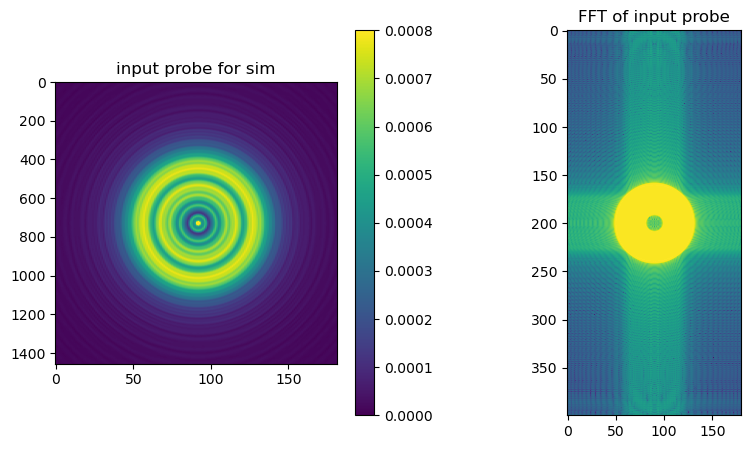

In [31]:


new_flux = 4.0e-8
probe_vmax = 8e-4
probe_aspr = voxel_size[0]/voxel_size[1]
recon_FFT_vmin = -5
recon_FFT_vmax = 0
n_probe_modes = int(np.max(scan_identifier_list) + 1)


orig_csaxs_probe, model_probes = pg.generate_model_probe(
    lambda_val=lambda_val,
    voxel_size=voxel_size,
    crop_window_size=crop_window_size,
    scan_identifier_list=scan_identifier_list
)


plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(torch.abs(model_probes[:,:,0]).cpu(),aspect=probe_aspr,vmin=0,vmax=probe_vmax), plt.colorbar()
plt.title("input probe for sim")

plt.subplot(1,2,2)
this_exit_wave_crop = v2.CenterCrop(size=(crop_window_size))(torch.abs(torch.fft.fftshift(torch.fft.fft2((model_probes[:,:,0]))))+1e-20)
plt.imshow(torch.log(this_exit_wave_crop).cpu(),aspect=1)
plt.title("FFT of input probe")


# This cell sets pytorch relevant initial parameters for the optimisaiton, and defines parameter tensors, optimizers and learning rates.

# this cell defines parameters and optimizers based on previously given input settings.

full area covered by optimizable volume: 3.75000E+02 um
using multiple probe modes
final param size for this sim: 1 748 900
position optimization on
using n scans per pixel
using gradient accumulation
TV is calculated over entire volume
using noise addition
tvx alpha tensor(10., device='cuda:0')
tvy alpha 1
patience (number of iters before reducing LR): 3


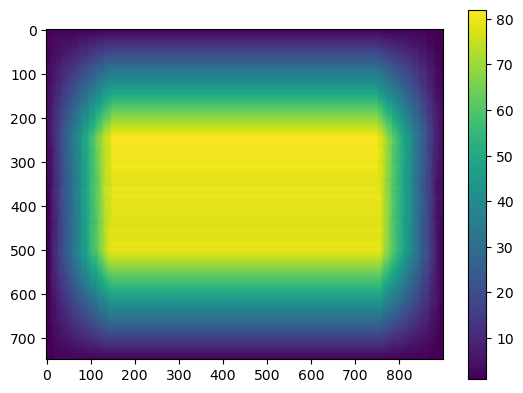

In [36]:

print("full area covered by optimizable volume:", "%5.5E" % (slab_thickness*full_sim_size[2]*1e6), "um" )
yzaspr = (slab_thickness*downscaling_factor_z)/(voxel_size[1]*downscaling_factor_y)
volsizeratio = xr_z_size/xr_y_size
xy_voxel_size_ratio = voxel_size[0]/voxel_size[1]

xr_x_size = 1 #leave as 1
viewing_slice = 5 #not used
yzpad = 0 #extra pad. This is from legacy code, but is solved by applying beam footprint masks elsewhere in code. Best left to zero.


if using_n_scans_per_pixel == True and do_gradient_accumulation == False:
    print("cannot have n_scans_per_pixel div if gradient accumulation is not used, setting ot true")
    do_gradient_accumulation == True

if use_multiple_probe_modes == True:
    print("using multiple probe modes")

    probe_in = model_probes.clone()

else:
    print("not using multiple probe modes")

    
probe_prop_amt = torch.nn.Parameter(torch.tensor(1e-5))


if load_previous:
    probes_presave = torch.load('/home/lubs/pytorchnotebooks/Au_realdatatensor_probes_050608_conv_27-11-2024.pt')
    # probe_in = torch.nn.Parameter(probes_presave)
    probes_param = torch.nn.Parameter(probes_presave)
else:
    probes_param = torch.nn.Parameter(probe_in)



print("final param size for this sim:", xr_x_size,xr_y_size+yzpad*2,xr_z_size+yzpad*2)


if optimize_scan_offsets == True:
    subpixel_shifts_z = torch.nn.Parameter(-((torch.tensor((np.round(pz_voxels,decimals=0) - pz_voxels))*voxel_size[0])).clone())
    subpixel_shifts_y = torch.nn.Parameter((torch.tensor((np.round(px_voxels,decimals=0) - px_voxels))*voxel_size[1]).clone())
    hx_shift = torch.nn.Parameter(torch.rand(n_probe_modes)*1e-13)
    hz_shift = torch.nn.Parameter(torch.rand(n_probe_modes)*1e-13)
    scan_positions_optim = torch.optim.SGD([{'params': [subpixel_shifts_z,subpixel_shifts_y], 'lr': scan_positions_LR_fine},{'params': [hx_shift], 'lr': scan_positions_LR_coarse},{'params': [hz_shift], 'lr': scan_positions_LR_coarse}])
    print("position optimization on")

if oversample_structure == True:
    
    xr = torch.nn.Parameter(torch.rand(1,xr_y_size,xr_z_size*oversample_factor)*init_xr_scaling_factor+init_xr_substrateamt)#torch.nn.Parameter((create_iso_random_initguess(xr_x_size,xr_y_size+yzpad*2,(xr_z_size+yzpad*2)*oversample_factor,(yzaspr))*init_xr_scaling_factor+init_xr_substrateamt))
else:
    oversample_factor = 1
    xr = torch.nn.Parameter((create_iso_random_initguess(xr_x_size,xr_y_size+yzpad*2,xr_z_size+yzpad*2,(yzaspr))*init_xr_scaling_factor+init_xr_substrateamt))



n_scans_per_pixel = (torch.ones_like(xr))
#if youre using it or not:

for n1 in range(len(new_yposindex)):
    n_scans_per_pixel[:,(new_yposindex[n1][0]+yzpad):(new_yposindex[n1][1]+yzpad),
                      (new_zposindex[n1][0]+yzpad):(new_zposindex[n1][1]+yzpad)] += 1 

plt.imshow(n_scans_per_pixel[0,:,:].cpu()), plt.colorbar()

if using_n_scans_per_pixel:
    print("using n scans per pixel")
else:
    print("not using n scans per pixel")


#model noise. not needed im simulated data. And so we set noise_guess to zero.

noise_guess = torch.nn.Parameter(torch.clamp(torch.normal(torch.ones(crop_window_size[0],crop_window_size[1],num_scans)*noise_mean,torch.ones(crop_window_size[0],crop_window_size[1],num_scans)*noise_std),min=0))

# Create an optimizer for the parameter xr #good lr is 2e-3!!
#normal optim
#are you doing gradient accumulation?
if do_gradient_accumulation == True:
    print('using gradient accumulation')
else:
    print('not using gradient accumulation')

if use_per_scan_TV == True:
    print('TV is calculated per scan area')
else:
    print('TV is calculated over entire volume')


if use_noise == 1:
    print('using noise addition')
else:
    print('not using noise addition')

#### Are you using rprop or Adam ?


if do_gradient_accumulation == 0:
    optimizer = torch.optim.RAdam([{'params': [xr], 'lr': init_xr_learning_rate,'weight_decay':0}])      
else:
    optimizer = torch.optim.SGD([{'params': [xr], 'lr': init_xr_learning_rate,'weight_decay':0}])      
    optimizer_adam = torch.optim.Adam([{'params': [xr], 'lr': 8e-3,'weight_decay':0}])
probe_params = [ {'params': [probes_param], 'lr': 5e-2, 'weight_decay': 1e-20}]

#noise optim is set to zero as it is not used in simulated data.
noise_optim = torch.optim.RAdam([{'params': [noise_guess], 'lr': 0}])  

probe_optimizer = torch.optim.SGD(probe_params)
#scheduler for probe
probe_LR_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(probe_optimizer, mode='min', 
                    factor=0.5, patience=4, threshold=0.0001, threshold_mode='rel',
                    cooldown=0, min_lr=0, eps=1e-07)

prop_optim = torch.optim.RAdam([{'params': [probe_prop_amt], 'lr': probe_prop_LR}]) #not used at the moment, but if probe propagation distance is to be optimized.

loss_tracker = np.zeros((num_iters,num_scans))
total_sim_start_time = time.time()
iters_out = torch.tensor([])
dzz = 0
dzy = 0
tvx_alpha =  tvx_strength*(xr_x_size*slab_thickness*downscaling_factor_z)/(params_size[0]*voxel_size[0]) #weight for TV in x direction
print("tvx alpha",tvx_alpha)
tvy_alpha = tvy_strength#weight for TV in y direction
print("tvy alpha",tvy_alpha)
tvz_alpha = tvz_strength #weight for TV in z direction
tvt_alpha = total_TV_strength #total weight for all TV penalties  #if parial voxels, 1e-7 is typical, multiply by 1e6 or so if using complex


divergence_thr = 2
xrg = torch.zeros_like(xr)
# PFM = torch.zeros_like(probefluxmult)
# orig_probe_max = torch.max(probe_amp)
print("patience (number of iters before reducing LR):",(divergence_thr+1))
postresizeprobemask_rad = 95
psr = probes_param.size(0)/probes_param.size(1)
wave_deletion_mask = 1
divergence_count = 0



In [37]:
if oversample_structure:
    new_zposindex = [(int(x * oversample_factor), int(y * oversample_factor)) for x, y in zposindex]
        

In [38]:

torch.cuda.empty_cache()
optimizer.zero_grad()
probe_optimizer.zero_grad()
prop_optim.zero_grad()
gc.collect()
# if use_noise == 1:
    # noise_optim.zero_grad()
gpu_memcheck()

Currently allocated memory: 146 MB


In [39]:

EWCI = [528,528,1,1] #EWCI = Exit Wave Crop Indices. Crop the exit wave of the simulation to match the size of the data. Useful when working with real experimental data.


## Run a quick multislice forward simulation for diagnostic purposes.

### Here you can check that the beam comes in, reflects, and exits, all within the space of the volume you defined.
### this is a good point to check your simulation settings are okay, or if you need to go back and modify something, without having to run the entire reconstruction. It should only take a few seconds on a GPU
#### The simulation follows this same code.

exit wave norm tensor(40.9561, device='cuda:0')
exit wave max tensor(0.6611, device='cuda:0')


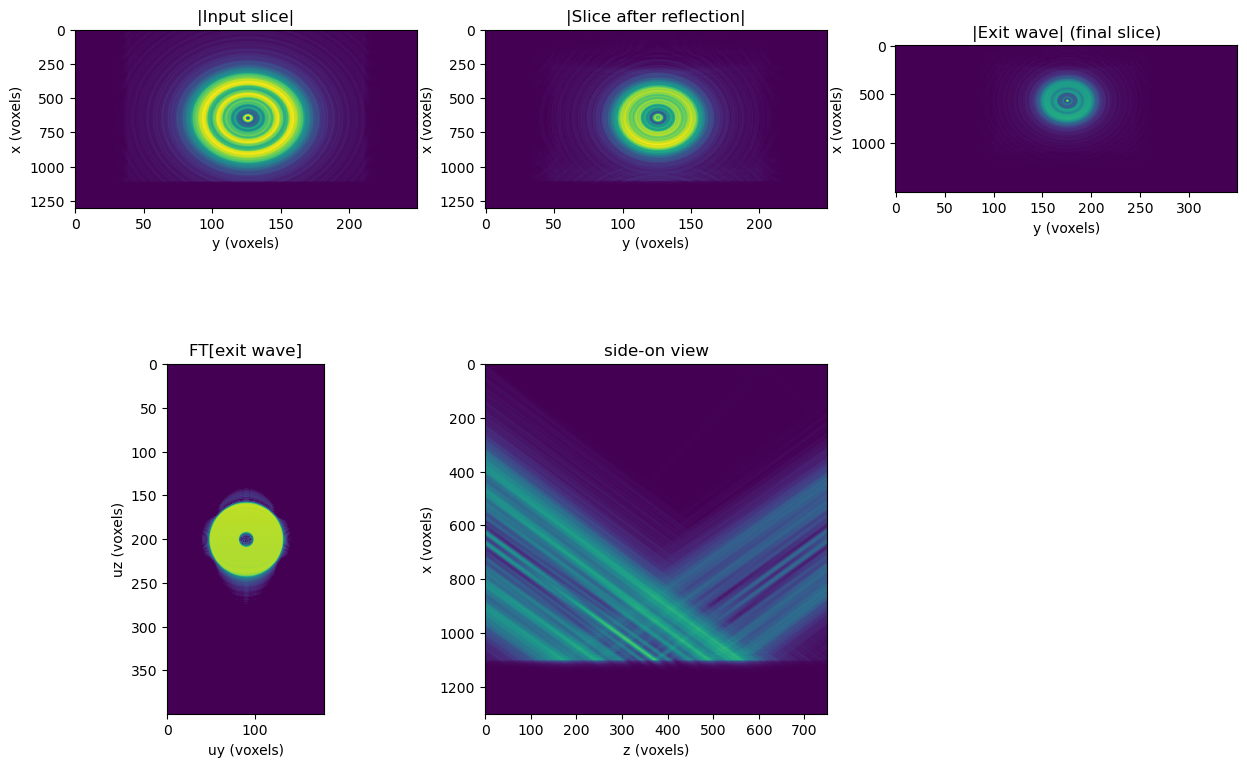

In [40]:

iii = 25
with torch.no_grad():
    
    teststrin =  torch.zeros(params_size)
        
    probein = pg.combine_probe_modes(probes_param,0,scan_identifier_list) 
    probesize = probein.size()
    pre_EW,pre_post_amt,probe_insertion_Y = pg.MSForward_GI_SS_novol_partialvoxel_pre(
                        torch.zeros(params_size),lambda_val,
                        full_sim_size, params_size, voxel_size, slab_thickness,
                        test_inc_angle, slab_pad_pre, slab_pad_post, probein,
                        probe_buffer,probe_substrate_buffer,1,0,substrate_layers,init_xr_substrateamt,0,0,0,0,0,Audelta,Aubeta)
    midEW,midslice,sideslice = pg.MSForward_GI_SS_novol_partialvoxel_mid(teststrin,lambda_val,pre_EW,
                   full_sim_size,params_size,voxel_size,slab_thickness,test_inc_angle,(substrate_layers),Audelta,Aubeta)

    exit_wave = pg.MSForward_GI_SS_novol_partialvoxel_post(xr,lambda_val,midEW,
                    full_sim_size,params_size,voxel_size,slab_thickness,test_inc_angle,(substrate_layers),pre_post_amt,post_prop_dist_multiplier,probe_insertion_Y,probesize,init_xr_substrateamt,Audelta,Aubeta)

    F1 = torch.abs(torch.fft.fftshift(torch.fft.fft2(exit_wave)))
    F1 = torch.nn.functional.interpolate(F1.unsqueeze(0).unsqueeze(0),size=(probesize),mode='bilinear').squeeze()
    F1 = (F1)[EWCI[0]:-EWCI[1],EWCI[2]:-EWCI[3]]


    
    
    plt.figure(figsize=[15,10])
    plt.subplot(2,3,1)
    plt.imshow(torch.abs(pre_EW).cpu(),aspect=0.1)
    plt.title('|Input slice|')
    plt.xlabel("y (voxels)")
    plt.ylabel("x (voxels)")
    plt.subplot(2,3,2)
    plt.imshow(torch.abs(midEW).cpu(),aspect=0.1)
    plt.title('|Slice after reflection|')
    plt.xlabel("y (voxels)")
    plt.ylabel("x (voxels)")
    plt.subplot(2,3,3)
    plt.imshow(torch.abs(exit_wave).cpu(),aspect=0.1)
    plt.title('|Exit wave| (final slice)')
    plt.xlabel("y (voxels)")
    plt.ylabel("x (voxels)")

    # plt.figure(figsize=[5,5])
    plt.subplot(2,3,4)
    plt.imshow(torch.log(torch.abs((F1))+1e-20).cpu(),aspect=1,vmin=recon_FFT_vmin,vmax=recon_FFT_vmax)
    plt.title("FT[exit wave]")
    plt.xlabel("uy (voxels)")
    plt.ylabel("uz (voxels)")
    
    # plt.figure(figsize=[10,5])
    plt.subplot(2,3,5)
    plt.imshow((torch.abs(sideslice.cpu())),aspect='auto')
    plt.title("side-on view")
    plt.xlabel("z (voxels)")
    plt.ylabel("x (voxels)")

    
    print("exit wave norm",torch.norm(torch.abs(F1)))
    print("exit wave max",torch.max(torch.abs(F1)))
    

## Assert that the exit wave simulation window size matches the data/detector window size.
### not needed for simulated data, but useful for real data.

In [41]:
F1_size = (F1).size()

print("size of GT  crop",crop_window_size)
print("size of EW",F1_size)
# print("difference",(F1_size[0] - crop_window_size[0]),(F1_size[1] - crop_window_size[1]))
# print("old EWCI", EWCI)
# print("new EWCI should be",EWCI[0]+(F1_size[0] - crop_window_size[0])/2,EWCI[2]+(F1_size[1] - crop_window_size[1])/2)
assert (F1_size[0] == crop_window_size[0]) & (F1_size[1] == crop_window_size[1]) , "EWCI isnt the same"

size of GT  crop [400, 180]
size of EW torch.Size([400, 180])


Text(0.5, 1.0, 'beam profile at midpoint')

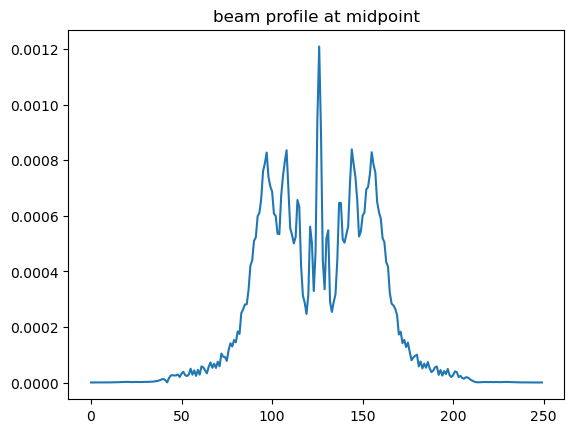

In [42]:

plt.figure()
plt.plot(((torch.abs(midslice.cpu()))[:,int(full_sim_size[2]/2)]))

plt.title("beam profile at midpoint")

## Define beam footprint mask. This will be to aid with a real space constraint in the volume.

torch.Size([1, 748, 900])


Text(0.5, 1.0, 'beam footprints binary mask')

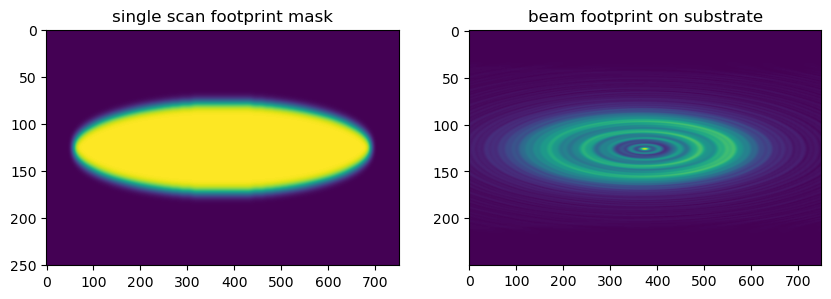

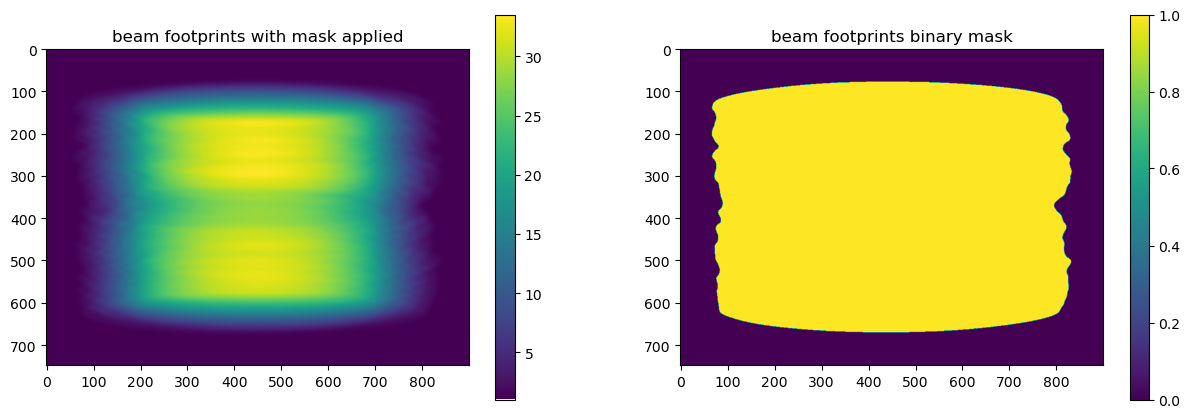

In [43]:
beam_footprint_radius_y_voxels = (1.9e-6/(voxel_size[1]*downscaling_factor_y))
beam_footprint_radius_z_voxels = (1.9e-6*oversample_factor/np.sin(np.deg2rad(inc_angle_list[0])))/(slab_thickness*downscaling_factor_z)
beam_footprint_ratio = beam_footprint_radius_z_voxels/beam_footprint_radius_y_voxels
beam_footprint_buffer = 1
beam_footprint_blur = 5
beamfootprints = (torch.ones(1,xr.size(1),xr.size(2)))
print(beamfootprints.size())
for n1 in range(len(new_yposindex)):
    
    beamfootprints[:,(new_yposindex[n1][0]):(new_yposindex[n1][1]),
                      (new_zposindex[n1][0]):(new_zposindex[n1][1])] += pg.make_prop_mask(beamfootprints[0,int(new_yposindex[n1][0]):int(new_yposindex[n1][1]),int(new_zposindex[n1][0]):int(new_zposindex[n1][1])].rot90(1),(beam_footprint_radius_y_voxels+beam_footprint_buffer).cpu().numpy(),beam_footprint_blur,beam_footprint_ratio).rot90(-1)+1e-3


    
iii = 2
thisxrtest = xr[0,int(new_yposindex[iii][0]+yzpad):int(new_yposindex[iii][1]+yzpad),
                   int(new_zposindex[iii][0]+yzpad):int(new_zposindex[iii][1]+yzpad)]
masktest1 = pg.make_prop_mask(thisxrtest.rot90(1),(beam_footprint_radius_y_voxels+beam_footprint_buffer).cpu().numpy(),beam_footprint_blur,beam_footprint_ratio).rot90(-1)+1e-4

plt.figure(figsize=[10,5])
plt.subplot(1,2,1)
plt.imshow(masktest1.detach().cpu(),aspect=2)
plt.title("single scan footprint mask")
plt.subplot(1,2,2)
plt.imshow(torch.abs(midslice).detach().cpu(),aspect=2/oversample_factor)
plt.title("beam footprint on substrate")
plt.figure(figsize=[15,5])
plt.subplot(1,2,1)
plt.imshow(beamfootprints[0,:,:].cpu(),aspect=0.9), plt.colorbar()
plt.title("beam footprints with mask applied")

beam_footprints_binary = beamfootprints.clone()
beam_footprints_binary[beam_footprints_binary<2] = 0
beam_footprints_binary[beam_footprints_binary>=2] = 1


plt.subplot(1,2,2)
plt.imshow(beam_footprints_binary[0,:,:].cpu(),aspect=0.9), plt.colorbar()
plt.title("beam footprints binary mask")



Text(0.5, 0, 'z (μm)')

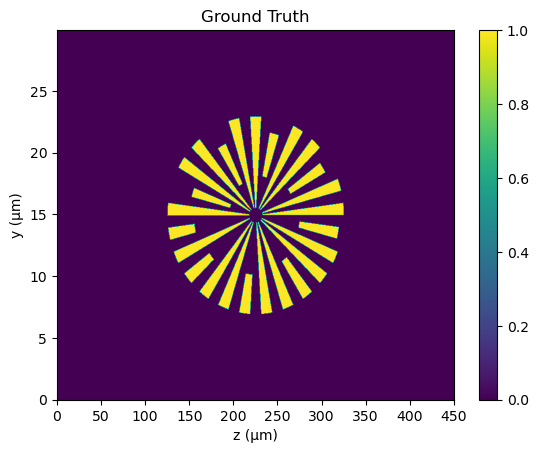

In [46]:
#create ground truth structure.

modulated_spokes_inds = {
    1: (60, 150),
    4: (70, 160),
    7: (80, 170),
    10: (90, 180),
    13: (100, 190),
    16: (110, 200),
    19: (120, 200),
    22: (130, 200),
    24: (140, 200),
    # 25: (100, 200),
    # 28: (110, 200),
    # 31: (120, 200),
    # 34: (130, 200),

    
    
}
ground_truth_image = pg.generate_per_spoke_modulated_siemens_star(width=xr_z_size,
                                                               height=xr_y_size,
                                                               num_spokes=25,
                                                               r_inner=15, 
                                                               r_outer=200,
                                                               modulated_spokes=modulated_spokes_inds)
# ground_truth_image = generate_custom_modulated_siemens_star(
#     width=xr_z_size, height=xr_y_size,num_spokes=35,r_inner=15, r_outer=200,r_inner_alt=80, r_outer_alt=150,modulated_spoke_indices=[1,4,8,13,19,26,34])
ny, nx = ground_truth_image.squeeze().shape
extent = [0, nx * slab_thickness.cpu()*1e6, 0, ny * voxel_size[1].cpu()*1e6]
plt.imshow(ground_truth_image.squeeze().cpu(),extent=extent,aspect='auto'),plt.colorbar()
plt.title("Ground Truth")
plt.ylabel("y (μm)")
plt.xlabel("z (μm)")


In [47]:
#create simulated diffrac patterns:
with torch.no_grad():
    GTs = torch.zeros_like(GT)
    this_GT_str = ground_truth_image
    for iii in range(num_scans):
            
            print("creating sim data diffrac. patterns:",(iii+1), "/", num_scans,end="\r")
            this_xr = pg.fill_3d_tensor(this_GT_str[0,int(new_yposindex[iii][0]+yzpad):int(new_yposindex[iii][1]+yzpad),
                           int(new_zposindex[iii][0]+yzpad):int(new_zposindex[iii][1]+yzpad)],params_size[0],params_size,oversample_structure,oversample_factor)
            sim_probe_in = pg.combine_probe_modes(probes_param,0,scan_identifier_list)
            waveout,_ = pg.multislice_3stage(
                    this_xr,
                    full_sim_size, params_size, voxel_size, slab_thickness,lambda_val,
                    inc_angle_list[iii], slab_pad_pre, slab_pad_post,post_prop_dist_multiplier, sim_probe_in,
                    probe_buffer,probe_substrate_buffer,1,shift_amount,substrate_layers,
                    init_xr_substrateamt,top_buffer,0,subpixel_shifts_y[iii],subpixel_shifts_z[iii],
                hx_shift[int(scan_identifier_list[iii])],hz_shift[int(scan_identifier_list[iii])],Audelta,Aubeta)
                #crop exit wave
            out1 = torch.abs(waveout[EWCI[0]:-EWCI[1],EWCI[2]:-EWCI[3]])#*mean_1d_perscan[:,:,iii]
            
            GTs[:,:,iii] = out1
            

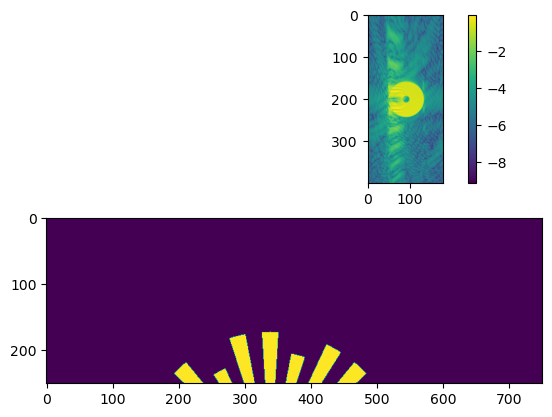

In [48]:
with torch.no_grad():
    # plt.imshow(this_xr[-2,:,:].cpu())
    plt.subplot(2,1,1)
    plt.imshow(torch.log(GTs[:,:,4]).cpu()),plt.colorbar()
    plt.subplot(2,1,2)
    plt.imshow(this_GT_str[0,int(new_yposindex[iii][0]+yzpad):int(new_yposindex[iii][1]+yzpad),
                           int(new_zposindex[iii][0]+yzpad):int(new_zposindex[iii][1]+yzpad)].cpu())

# Main Loop

### by default this prints out an image of the probe and reconstruction after each iteration.

this iter progress: [====================] 100%
1 / 50 8.13352E-03 mem used: 4682 MB MS fwd time 152.82 Bkwd time 0.33
typical loss 2.21E-02 typical tvx 0.00E+00 typical tvy 0.00E+00 typical tvz 0.00E+00 typical tv_total 0.00E+00 calculated learning rate 1.00E+05 calculated probe learning rate 5.00E-02


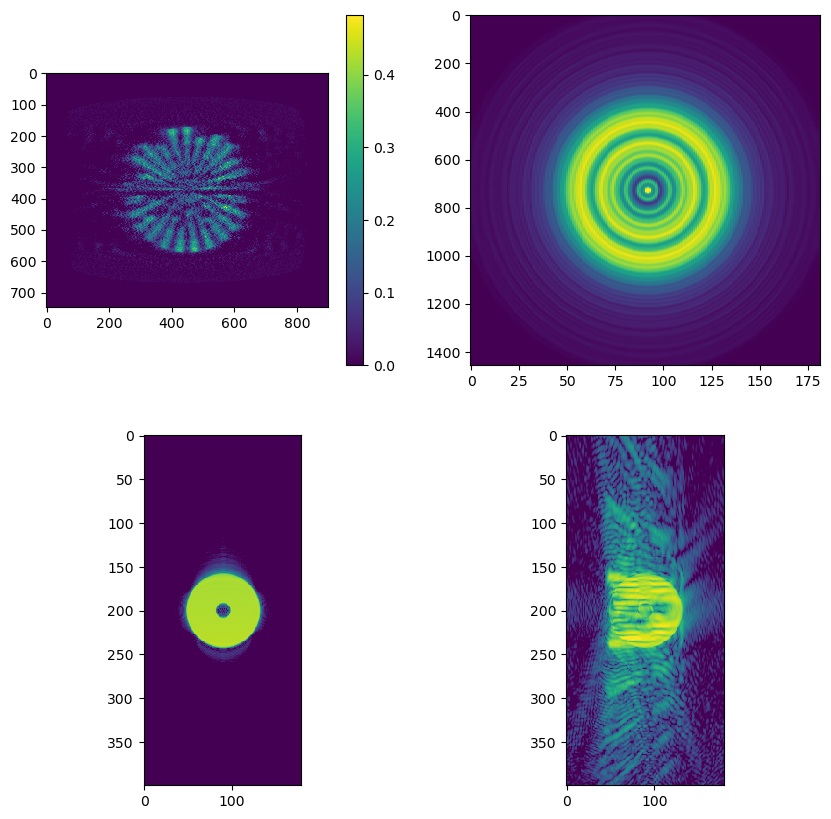

this iter progress: [===                 ] 13%

KeyboardInterrupt: 

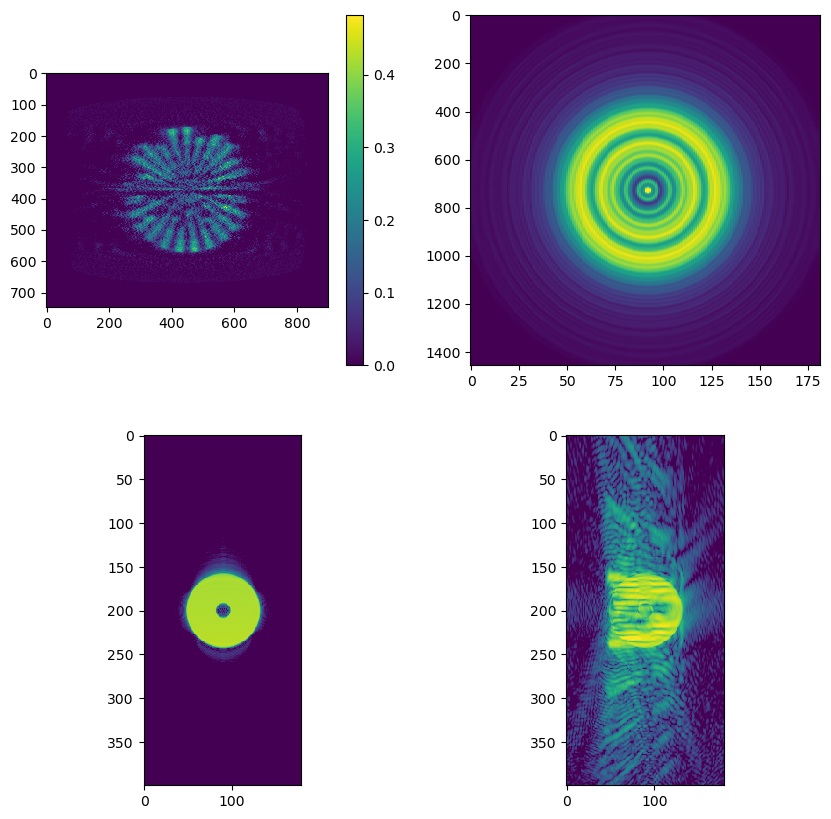

In [50]:
flux_ratio = 1
fig = plt.figure(figsize=[10,10])


for i in range(num_iters):

    mstime1 = time.time()
    scan_orders = (list(range(num_scans)))
    random.shuffle(scan_orders)
    scan_counter = 0
    #zero grad "storage" tensors
    probes_cumulative_grad = torch.zeros_like(probes_param)
    spsz_cumulative = torch.zeros_like(subpixel_shifts_z)
    spsy_cumulative = torch.zeros_like(subpixel_shifts_y)
    hx_cumulative = torch.zeros_like(hx_shift)
    hz_cumulative = torch.zeros_like(hz_shift)

    xrg *= 0

    for iii in scan_orders:
        #zero optimizers
        pg.zero_grads(optimizer,optimizer_adam,probe_optimizer,prop_optim,optimize_scan_offsets,scan_positions_optim,use_noise,noise_optim)
        #choose the corresponding probe for this scan.
        this_probe_in = pg.combine_probe_modes(probes_param,iii,scan_identifier_list)
         #choose the corresponding position of xr for this scan.
        this_xr = pg.fill_3d_tensor((xr)[0,int(new_yposindex[iii][0]+yzpad):int(new_yposindex[iii][1]+yzpad),
               int(new_zposindex[iii][0]+yzpad):int(new_zposindex[iii][1]+yzpad)],params_size[0],params_size,oversample_structure,oversample_factor)
        

        #begin forward pass of multislice:
        waveout,_ = pg.multislice_3stage(
            this_xr,
            full_sim_size, params_size, voxel_size, slab_thickness,lambda_val,
            inc_angle_list[iii], slab_pad_pre, slab_pad_post,post_prop_dist_multiplier, this_probe_in,
            probe_buffer,probe_substrate_buffer,wave_deletion_mask,shift_amount,substrate_layers,
            init_xr_substrateamt,top_buffer,0,subpixel_shifts_y[iii],
            subpixel_shifts_z[iii],hx_shift[int(scan_identifier_list[iii])],
            hz_shift[int(scan_identifier_list[iii])],Audelta,Aubeta)
        #crop exit wave
        out1 = torch.abs(waveout[EWCI[0]:-EWCI[1],EWCI[2]:-EWCI[3]])
        with torch.no_grad(): 
            out1.data[torch.isnan(out1.data)] = 0
        #apply Total Variation Penalties / other regularizers
        tvx,tvy,tvz,tv_total = pg.apply_tv(xr,tvx_alpha,tvy_alpha,tvz_alpha,tvt_alpha,i,iii,tv_start)
        #select corresponding diffraction pattern/data      
        this_GT = GTs[:,:,iii]#*detector_mask_crop

        #calculate the loss 
        if use_noise == 1:
            this_diff = (torch.abs((torch.abs(this_GT)) - (((out1)))))**2+noise_guess[:,:,iii]
            loss = torch.nanmean(this_diff)+tv_total
        else:
            loss = torch.nanmean((torch.abs((torch.abs(this_GT)) - (((out1)))))**2)+tv_total

        allocated_memory = torch.cuda.memory_allocated()
        backtime1 = time.time()
        
        ### calculate backward ###
        loss.backward()
        #after backward:
        #store + optimize scan offsets 
        pg.store_scan_offset_gradients(subpixel_shifts_z,subpixel_shifts_y,hx_shift,hz_shift,optimize_scan_offsets,i)
        #start storing gradients of the recon structure into xrg
        pg.store_xr_gradients(xr, xrg,iii, new_yposindex, new_zposindex, yzpad, i,do_gradient_accumulation)
        #accumulate grads for probe param and prop amt.
        with torch.no_grad():
            probes_cumulative_grad += probes_param.grad
            probes_cumulative_grad[torch.isnan(probes_cumulative_grad)] = 0
        pg.store_noise_gradients(noise_optim,noise_guess,use_noise,noise_mean,noise_std)
        backtime2 = time.time()
        scan_counter += 1
        loss_tracker[i,iii] = loss.item()
        pg.print_progress_bar(scan_counter + 1, num_scans)
        
        ### end loop over scans###
    
    #reapply gradients and actually update the structure
    pg.apply_gradients_and_update(optimizer,optimizer_adam,xr,xrg,beamfootprints,params_size,beam_footprints_binary,
                                  do_gradient_accumulation,using_n_scans_per_pixel,i,
                                  spsy_cumulative,spsz_cumulative,hx_cumulative,hz_cumulative,
                                  subpixel_shifts_y,subpixel_shifts_z,hx_shift,hz_shift,
                                  probes_param,probes_cumulative_grad,num_scans)
    pg.apply_probe_constraints(probestart,probe_optimizer,probe_grads_target,probes_cumulative_grad,num_scans,i,probes_param,psr)
    pg.apply_LR_scheduler(i,divergence_count_start,loss_tracker,divergence_thr,grads_target,probe_grads_target,optimizer,optimizer_adam,probe_optimizer,tvt_alpha) #this reduces LRs if loss function is increasing.             
    

    xr.data = torch.clamp(xr.data,0,params_size[0])
    mstime2 = time.time()
       
    
    #print metrics for losses and parameters
    pg.print_metrics(hz_shift,hx_shift,i,iii,num_iters,loss_tracker,allocated_memory,mstime2,mstime1,backtime2,backtime1,GT,out1,tvx,tvy,tvz,tv_total,optimizer,probe_optimizer)

    #print output at each iteration. Comment out to turn off.
    fig = pg.plot_reconstruction(fig, xr, iii, probes_param, out1, this_GT,
                        dzz, dzy, yzpad, use_multiple_probe_modes,
                        probe_vmax, recon_FFT_vmin, recon_FFT_vmax,
                        psr, i, flux_ratio,scan_identifier_list)
    
    
total_sim_end_time = time.time()
print()
print("finished")

print("total time for",num_iters,"iters:", "%2.2f" % ((total_sim_end_time-total_sim_start_time)/60),"min")

# View Reconstruction Outputs

In [57]:
def display_3d_tensor(A,structure_height,params_size):
    width,height = A.shape
    output3d = A.repeat(structure_height,1,1)-torch.arange(structure_height).unsqueeze(1).unsqueeze(1).expand(structure_height,width,height)
    output3d = torch.clamp(output3d,0,1)
    return output3d.flip(0)
        

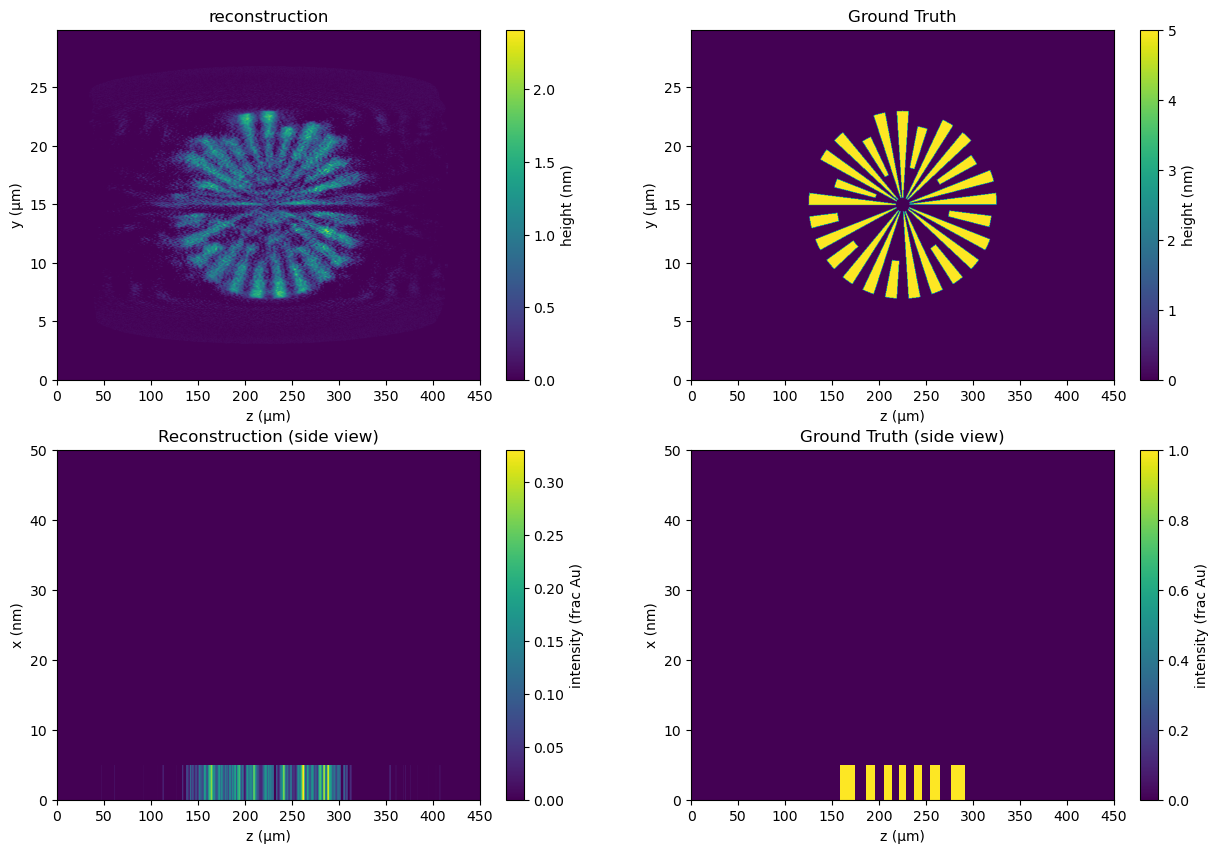

In [74]:
with torch.no_grad():
    plt.figure(figsize=[15,10])
    plt.subplot(2,2,1)
    
    
    ny, nx = xr.squeeze().shape
    extent = [0, nx * slab_thickness.cpu()*1e6, 0, ny * voxel_size[1].cpu()*1e6]
    plt.imshow((xr*voxel_size[0]*1e9).squeeze().cpu(),extent=extent,aspect='auto')
    cbar1 = plt.colorbar()
    cbar1.set_label("height (nm)")
    plt.title("reconstruction")
    plt.ylabel("y (μm)")
    plt.xlabel("z (μm)")

    plt.subplot(2,2,2)
    plt.imshow((ground_truth_image*voxel_size[0]*1e9).squeeze().cpu(),extent=extent,aspect='auto')
    plt.title("Ground Truth")
    plt.ylabel("y (μm)")
    plt.xlabel("z (μm)")
    cbar2 = plt.colorbar()
    cbar2.set_label("height (nm)")

    plt.subplot(2,2,3)
    recon_3d = display_3d_tensor(xr.squeeze(),params_size[0],params_size)
    nz,ny, nx = recon_3d.shape
    extent2 = [0, nx * slab_thickness.cpu()*1e6, 0, nz * voxel_size[0].cpu()*1e9]
    plt.imshow((recon_3d)[:,250,:].cpu(),extent=extent2,aspect='auto',interpolation='none')
    plt.title("Reconstruction (side view)")
    plt.ylabel("x (nm)")
    plt.xlabel("z (μm)")
    cbar2 = plt.colorbar()
    cbar2.set_label("intensity (frac Au)")

    plt.subplot(2,2,4)
    GT_3d = display_3d_tensor(ground_truth_image.squeeze(),params_size[0],params_size)
    plt.imshow(GT_3d[:,250,:].cpu(),extent=extent2,aspect='auto',interpolation='none')
    plt.title("Ground Truth (side view)")
    plt.ylabel("x (nm)")
    plt.xlabel("z (μm)")
    cbar2 = plt.colorbar()
    cbar2.set_label("intensity (frac Au)")



Text(0.5, 0, 'n iterations')

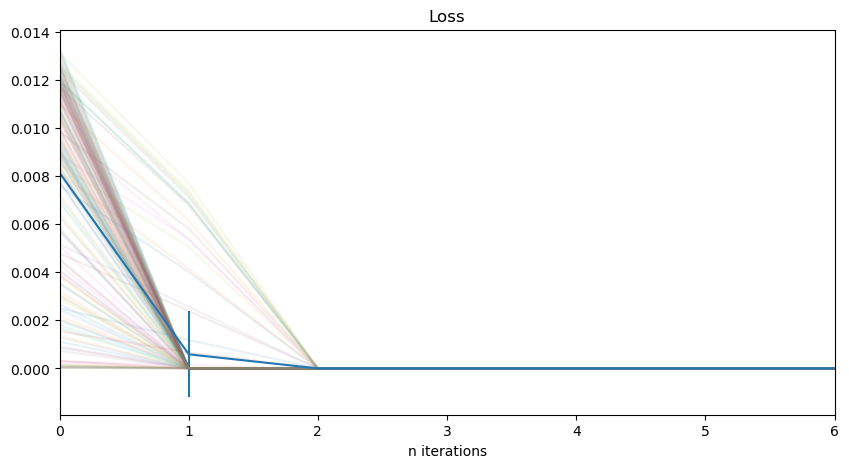

In [52]:

plt.figure(figsize=[10,5])

lossmeans = np.mean(loss_tracker+1e-20,1)
losserrs = np.std(loss_tracker+1e-20,1)
plt.errorbar(np.arange(0,num_iters),lossmeans,losserrs)
plt.plot((loss_tracker),alpha=0.1)
plt.xlim([0,(i+5)])
plt.title("Loss")
plt.xlabel("n iterations")

# Save Outputs

In [ ]:
save_filepath = '/outputs/' 
save_filename = 'demo_script_output'
today_date = datetime.today().strftime('%d-%m-%Y')
full_filename = f"{save_filepath}{save_filename}_{today_date}.pt"
print("full filename",full_filename)

metadata = {
    "slab_thickness": slab_thickness,
    "simulation_size": full_sim_size,
    "voxel_size": voxel_size,
    "probes": probes_param,
    "oversample_factor": oversample_factor,
    "num_inc_angles": len(np.unique(inc_angle_list)),
    "inc_angles": np.unique(inc_angle_list),
    "num_scans": num_scans,    
    "loss_function": loss_tracker,

    "GT": ground_truth_image,
    

}

# Save tensor and metadata
torch.save({"recon": xr.detach(), "metadata": metadata}, full_filename)

print(f"\n Reconstruction and metadata saved successfully to:\n→ {os.path.abspath(full_filename)}\n")